In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision import transforms
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import json
from sklearn.model_selection import train_test_split

# Dataset, dataloader

In [2]:
class MyDataset(Dataset):
    def __init__(self, train=True, transform=None, target_transform=None):
        self.img_dir = 'datasets/five_k_expert_a_small/images/'
        if train:
            self.label_dir = 'datasets/five_k_expert_a_small/train_data.json'
        else:
            self.label_dir = 'datasets/five_k_expert_a_small/test_data.json'
            
        with open(self.label_dir) as f:
            self.image_fn_and_illuminant = json.load(f)

        self.transform = transform

    def __len__(self):
        return len(self.image_fn_and_illuminant)

    def __getitem__(self, index):
        image_fn, illuminant = self.image_fn_and_illuminant[index]
        
        # Read image
        path = os.path.join(self.img_dir, image_fn)
        image = read_image(path) / 255
        
        # Multiply image and illuminant
        illuminant = np.array(illuminant)
        image = np.multiply(image, illuminant[:, None, None])
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        # Convert to float32 (not use float64)
        return image.to(torch.float32), illuminant

In [3]:
my_transforms = transforms.Compose([
    transforms.Resize((128, 128))
])

train_dataloader = DataLoader(MyDataset(train=True, transform=my_transforms), 64, shuffle=True)
test_dataloader = DataLoader(MyDataset(train=False, transform=my_transforms), 64, shuffle=True)

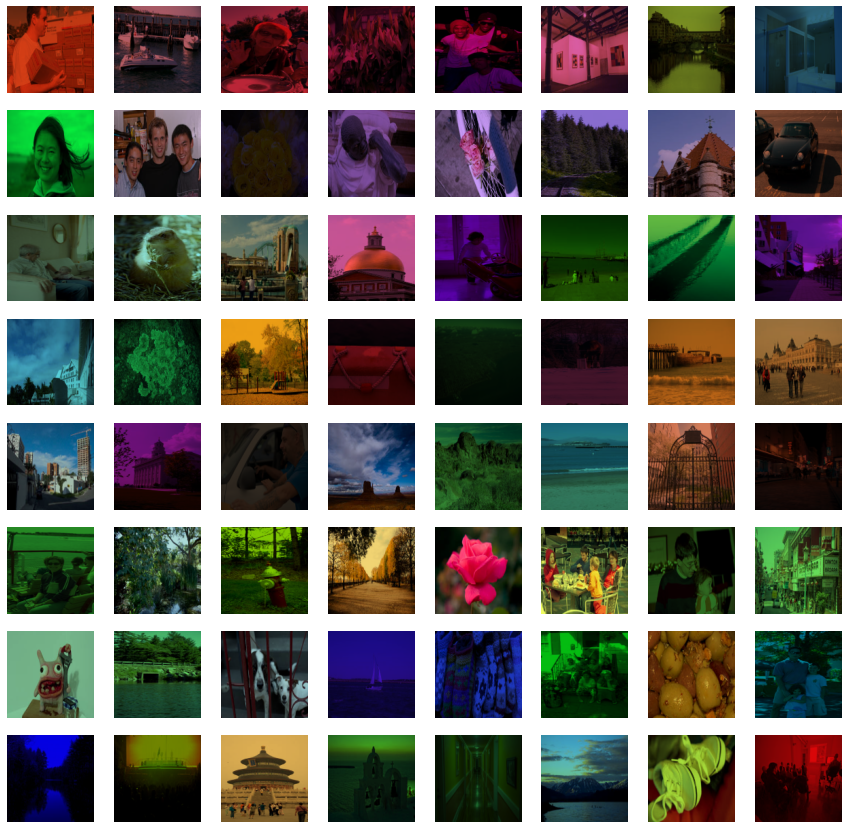

In [4]:
# Show batch
plt.figure(figsize=(15, 15))
images, labels = next(iter(train_dataloader))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = torch.permute(images[i], (1, 2, 0))
    plt.imshow(image)
    plt.axis("off")

# Estimate-Color Network

In [5]:
class EstimateColorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(24, 48, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(48, 96, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(96, 192, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(192, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 4, 3, stride=1, padding=1),
            nn.ReLU()
        )
        self.to_confident_map = nn.Sequential(
            nn.Conv2d(4, 1, 1),
            nn.Sigmoid()
        )
        self.to_illuminant_map = nn.Sequential(
            nn.Conv2d(4, 3, 1),
            nn.Sigmoid()
        )
        self.lastblock = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*192, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        confident_map = self.to_confident_map(x)
        illuminant_map = self.to_illuminant_map(x)
        illuminant_with_confident_map = torch.multiply(confident_map, illuminant_map)
        weigted_sum = torch.sum(illuminant_with_confident_map, dim=(2,3))
        normalized = torch.nn.functional.normalize(weigted_sum, dim=1, p=2)
        return normalized

    

In [6]:
device = 'cuda'
model = EstimateColorNetwork().to(device)

# Criterion, optimizer

In [7]:
def loss_fn(outputs, targets):
    return torch.arccos(torch.cosine_similarity(outputs, targets)).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train

In [8]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter('runs/EstimateColor_{}'.format(timestamp))
n_epochs = 60

def train_one_epoch(epoch_index):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    writer.flush()
    return last_loss

def validation():
    running_loss = 0.0
    for i, data in enumerate(test_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
    avg_loss = running_loss / (i + 1)
    return avg_loss

for epoch_index in range(n_epochs):
    print('EPOCH {}:'.format(epoch_index))

    model.train(True)
    train_loss = train_one_epoch(epoch_index)
    model.train(False)
    val_loss = validation()

    print('LOSS train {} valid {}'.format(train_loss, val_loss))
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : train_loss, 'Validation' : val_loss },
                    epoch_index + 1)
    writer.flush()


EPOCH 0:
  batch 10 loss: 0.43599027609789187
  batch 20 loss: 0.4487580516391151
  batch 30 loss: 0.43547014665281497
  batch 40 loss: 0.4243935084637016
  batch 50 loss: 0.4319349188872586
  batch 60 loss: 0.4388279642196163
  batch 70 loss: 0.4243770062881527
  batch 80 loss: 0.43499970004581867
  batch 90 loss: 0.43685834891142256
  batch 100 loss: 0.4280763972018858
  batch 110 loss: 0.4451037604577629
  batch 120 loss: 0.442724144620117
LOSS train 0.442724144620117 valid 0.43564734655458587
EPOCH 1:
  batch 10 loss: 0.43136226120191107
  batch 20 loss: 0.4409833891221394
  batch 30 loss: 0.43412349245978354
  batch 40 loss: 0.4221961369964542
  batch 50 loss: 0.4289914939444161
  batch 60 loss: 0.4384653642946252
  batch 70 loss: 0.43176519063859775
  batch 80 loss: 0.4300199243068482
  batch 90 loss: 0.432790132703751
  batch 100 loss: 0.4325752295483228
  batch 110 loss: 0.4129446858723143
  batch 120 loss: 0.4254689244962164
LOSS train 0.4254689244962164 valid 0.41514002930185

# Save & load

In [9]:
model_path = 'checkpoints/model_{}.pth'.format(timestamp)
torch.save(model.state_dict(), model_path)
print("Saved " + model_path)

Saved checkpoints/model_20220825_193116.pth


In [11]:
model = EstimateColorNetwork()
model.load_state_dict(torch.load("checkpoints/model_20220825_193116.pth"))
model.eval()

EstimateColorNetwork(
  (block1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


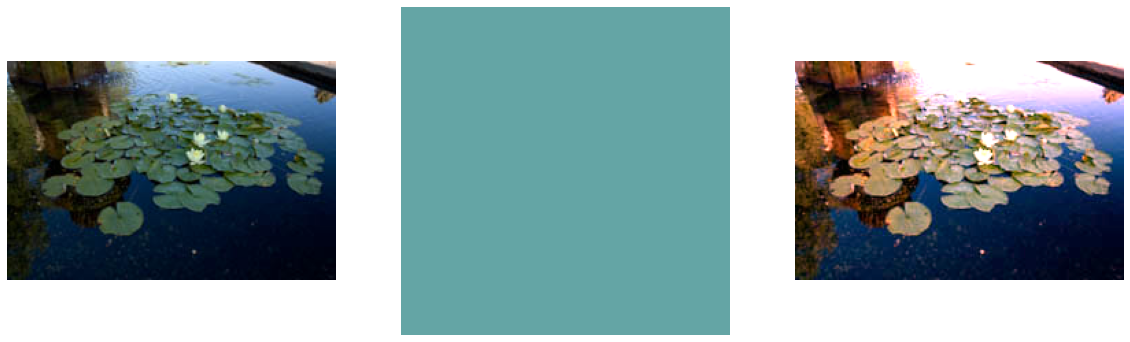

In [12]:
def infer(image_path):
    image = read_image(image_path) / 255
    if my_transforms:
        input = my_transforms(image).to(torch.float32)
    input = torch.unsqueeze(input, 0)
    with torch.no_grad():
        output = model(input)
    color = output[0]
    image_out = np.divide(image, color[:, None, None])

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(torch.permute(image, (1,2,0)))
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    image_width = image.shape[1]
    color_bar = np.ndarray((9, 9, 3))
    color_bar[:,:] = color
    plt.imshow(color_bar)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(torch.permute(image_out, (1,2,0)))
    plt.axis("off")




infer(r"C:\Users\dranh\Desktop\fivek-dataset\export\experta_small\a0004-jmac_MG_1384.jpg")
# infer('images/landscape-4175978_960_720.jpg')
# infer(r"images/NikonD5200_Indoor_Scene_18_6500_T_V.jpg")
# infer(r"C:\Users\dranh\Desktop\nikon\NikonD5200_Indoor_Scene_18_6500_C_AS.jpg")
# infer(r"images\test_image.png")

# Inference in test set

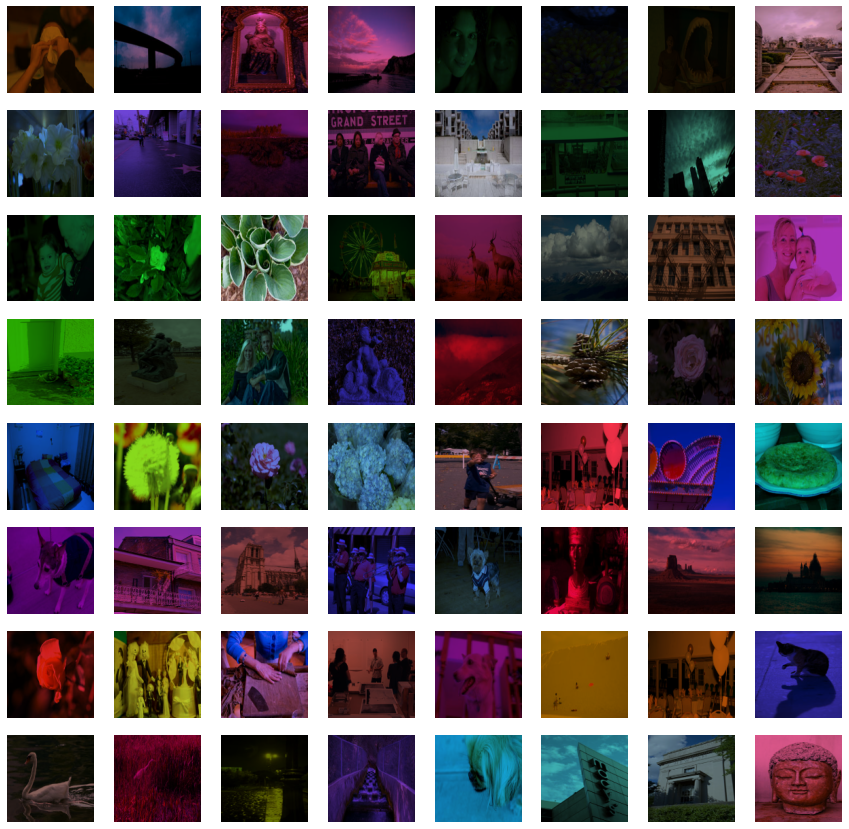

In [13]:
# Show a batch of test set
plt.figure(figsize=(15, 15))
images, labels = next(iter(test_dataloader))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = torch.permute(images[i], (1, 2, 0))
    plt.imshow(image)
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

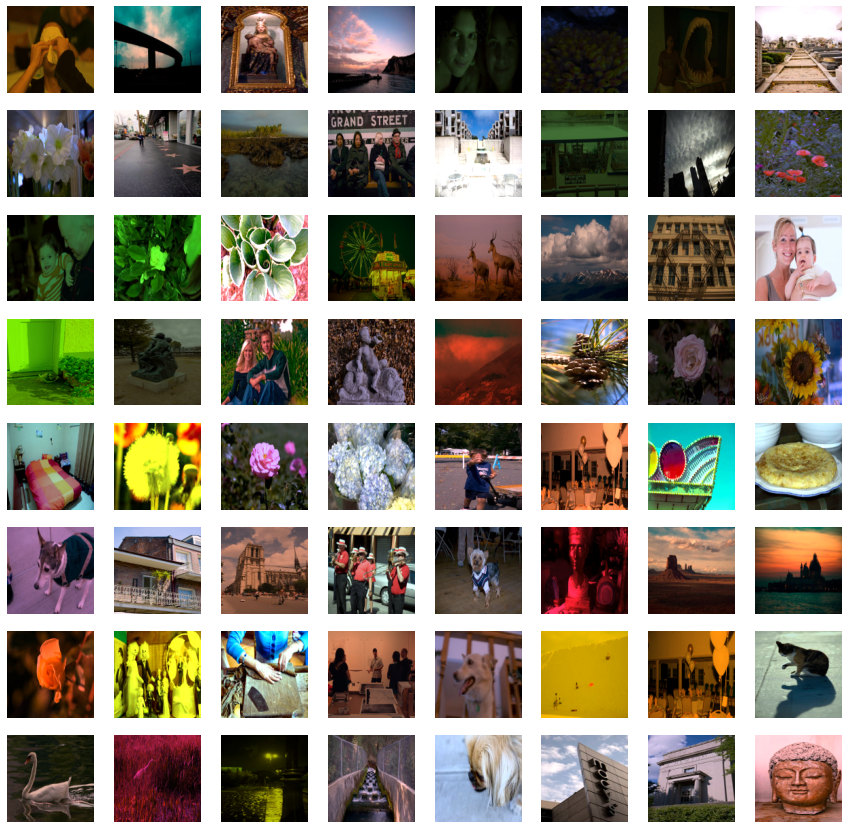

In [14]:
# Prediction
plt.figure(figsize=(15, 15))
with torch.no_grad():
    outputs = model(images)
for i in range(64):
    plt.subplot(8, 8, i + 1)
    estimated_illuminant = outputs[i]
    image = np.divide(images[i], estimated_illuminant[:, None, None])
    image = torch.permute(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis("off")